# Stochastic Pix2Pix For Seismic Conditioning

- <a>1. Introduction:  </a>
    - <a>1.1. Problem Statement</a>
    - <a>1.2. Method</a>
- <a>2. Imports</a>
- <a>3. Read in Data</a>
- <a>4. Conditional Model Generation</a>
- <a>5. Solution Space Exploration</a>
- <a>6. Summary</a>

<a></a>

## <a>1. Introduction: </a>


### <a>1.1. Problem Statement</a>
o. Generation of geological models that are consistent with both geological concepts and seismic data is difficult. Generally, a "cookie cutter approach" is adopted, however the inconsistency at the boundaries of seismic interpretation makes the models less realistic and useful.

<img src="cookie_cutter.png" title="A cute kitten" width="400" height="50" align="center">

o. The interger-type model parameters in rule- and object-based modeling method may also make hisotry matching more difficult.



### <a>1.2. Method</a>
o. Stochastic pix2pix method can be used to avoid the artifacts near the boundary of a reservoir model.

o. Reservoir models parameters are parameterized into independent Gaussian variables, which renders great advantage to different kinds of inversion.

o. Stochastic pix2pix model can be divided into a generator and a discriminator, While the generator attempts to produce more realistic models from the Gaussian variables, the discriminator learns to identify the fake models (y) obtained from the training images. They compete constantly until the generator yields reservoir models similar to training images, effectively fooling the discriminator. The mismatch of well interpreation and seismic interpretation is calculated as a loss function and added to the training process of Stochastic pix2pix model. 

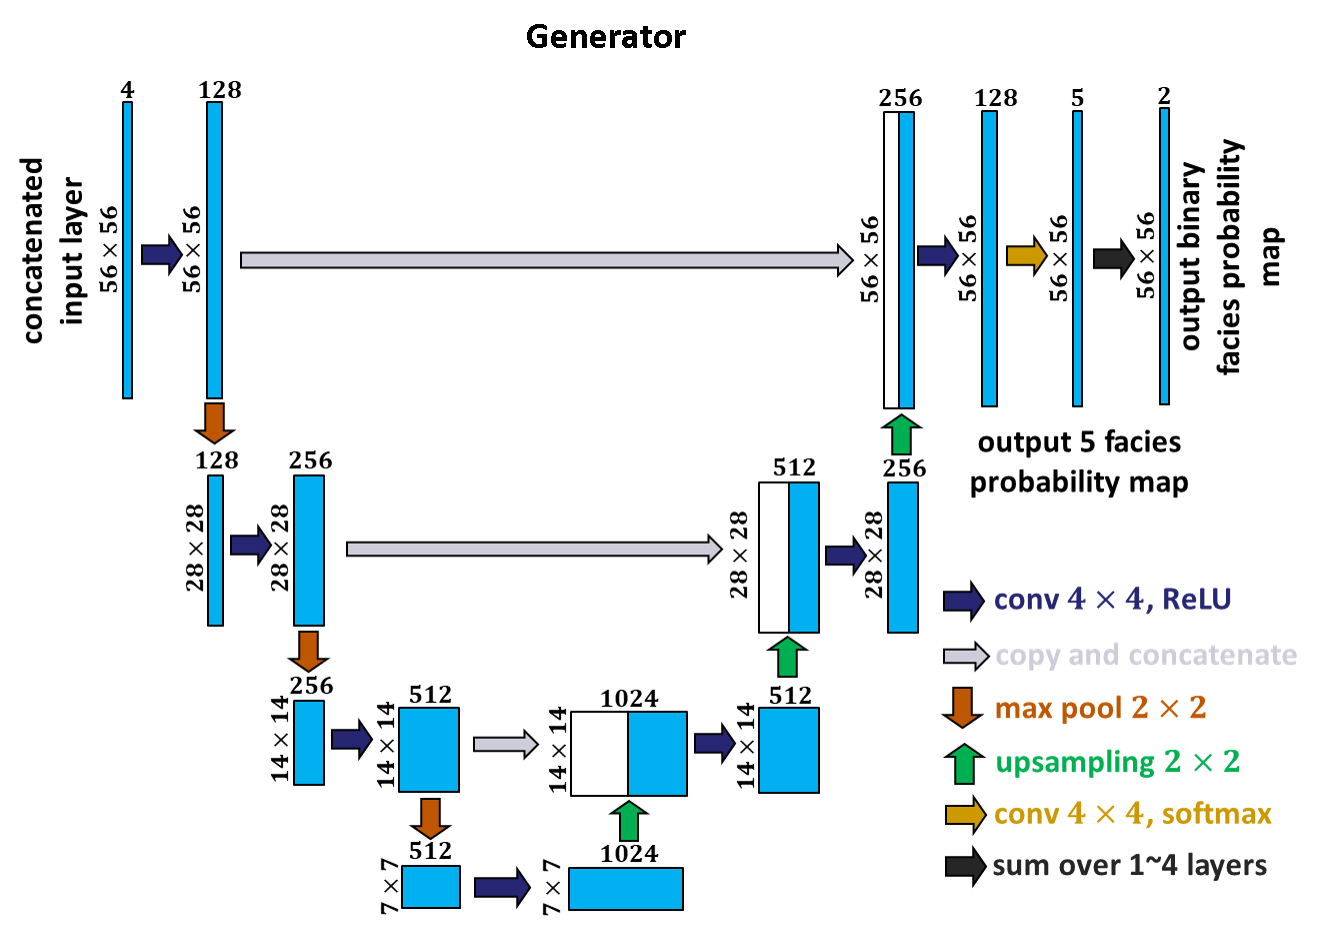
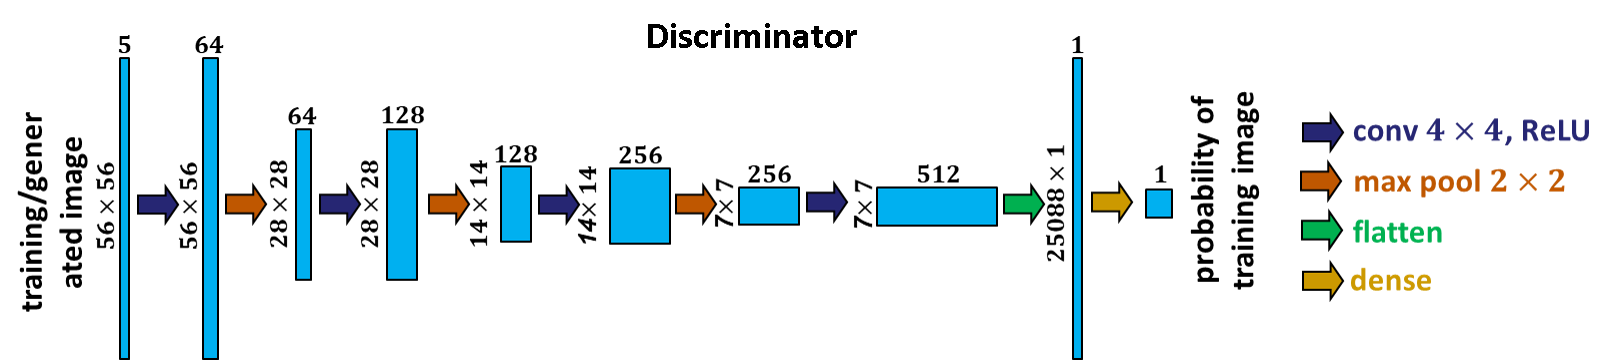




&emsp;Loss function of Stochastic pix2pix $$G_{sto}(x) = \textrm{arg min}_{G}{max}_{D}L_{CGAN}(G,D)+{\lambda}_{seis}L_{seismic}(G)+{\lambda}_{log}L_{well_log}(G)$$

where $G_{sto}(x)$ is the total loss function, G is the generator and D is the discriminator. ${\lambda}_{seis}$ and ${\lambda}_{log}$ are the certainty coefficients of the seismic and well-log interpretations. The weights, ${\lambda}_{i}$, must be small enough to avoid overfitting and to generate diverse realizations. 


## <a>2. Imports: </a>
import neccessary modules

In [1]:
from keras.models import model_from_yaml
import numpy as np
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import scipy.signal
import scipy.stats
from scipy import ndimage, misc
from PIL import Image
import matplotlib as mpl

Using TensorFlow backend.


## <a>3. Read in Data: </a>
Let's load the map of Texas as our seismic constraint

D:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  # Remove the CWD from sys.path while we load stuff.


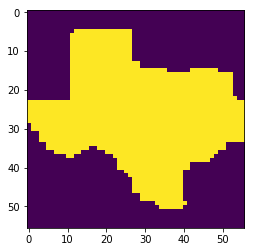

In [2]:
#read in raw image
img = Image.open('TX.jpg').convert('LA')
pix = np.array(img)[:,:,0]

# convert to binary map
pix[pix==255]=0
pix[pix>0]=1

#resize to the required size of stochastic pix2pix
image_resized = misc.imresize(pix[:,90:500], (56, 56))

#remove noise in the image
image_resized=scipy.signal.medfilt(image_resized,1)

#display
plt.imshow(image_resized)

#resize to the required size of stochastic pix2pix
image_resized=np.expand_dims(image_resized,axis=-1)
image_resized=np.expand_dims(image_resized,axis=0)

## <a>4. Conditional Model Generation: </a>

In [3]:
# load the generator of stochastic pix2pix and create model
yaml_file = open('generator.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()
generator = model_from_yaml(loaded_model_yaml)
# load weights into the generator
generator.load_weights("pos_predictor_full_seismic_only_0.h5")

# display the structure of generator
generator.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 56, 56, 2)    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 56, 56, 1)    0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 56, 56, 3)    0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 28, 28, 128)  6272        concatenate_1[0][0]              
__________

In [ ]:
#number of realizations to generate
N_sample=6

#reshape the input to be compatible with stochastic pix2pix
seismic=to_categorical(image_resized,num_classes=2)
seismic=np.tile(seismic,(N_sample,1,1,1))

#generate random latent parameters

res=np.random.normal(0,1,(N_sample,56,56,1))

#make plots
def facemaps(imgs,
            title='Facies Realization',
            myid='facies_'
                    ):
    NN=imgs.shape[0]//3
    cmap = mpl.colors.ListedColormap(['green', 'blue', 'red', 'black','yellow'])
    bounds = [-0.5, 0.5, 1.5, 2.5, 3.5, 4.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)    
    figures, axes=plt.subplots(NN, 3,figsize=(15,10))
    figures.tight_layout()
    
    for i in range(NN*3):
        N=NN*100+30+i+1
        fig = plt.subplot(N)
        
        plt.axis('off')
        plt.imshow(np.argmax(imgs[i],axis=-1),extent=(0, 1200, 896, 0),cmap=cmap,norm=norm)
         #dd1,dd2=stats.mode(result0,axis=0)
         #plt.imshow(dd1[0],cmap=cmap,norm=norm)
        cbar =plt.colorbar(ticks=np.linspace(0,4,5),fraction=0.046, pad=0.04)
        cbar.ax.set_yticklabels(['Shale', 'Levee', 'Abandon channel','Neck cutoff','Point bar'])  # vertically oriented colorbar

        plt.xticks(np.linspace(0, 1200,10))
        plt.yticks(np.linspace(0, 900,10))
#        plt.gca().invert_yaxis()
        plt.xlabel('X (m)')
        plt.ylabel('Y (m)')
        plt.title(title+str(i))
        
        
#conditional reservoir model generation
myfacies,pred_seismic=generator.predict([seismic,res])
facemaps(myfacies)

## <a>5. Solution Space Exploration: </a>

We expect to see continuous change in latent space corresponding to continuous change in model space, the change should also obey the migration rule of fluvial channel.

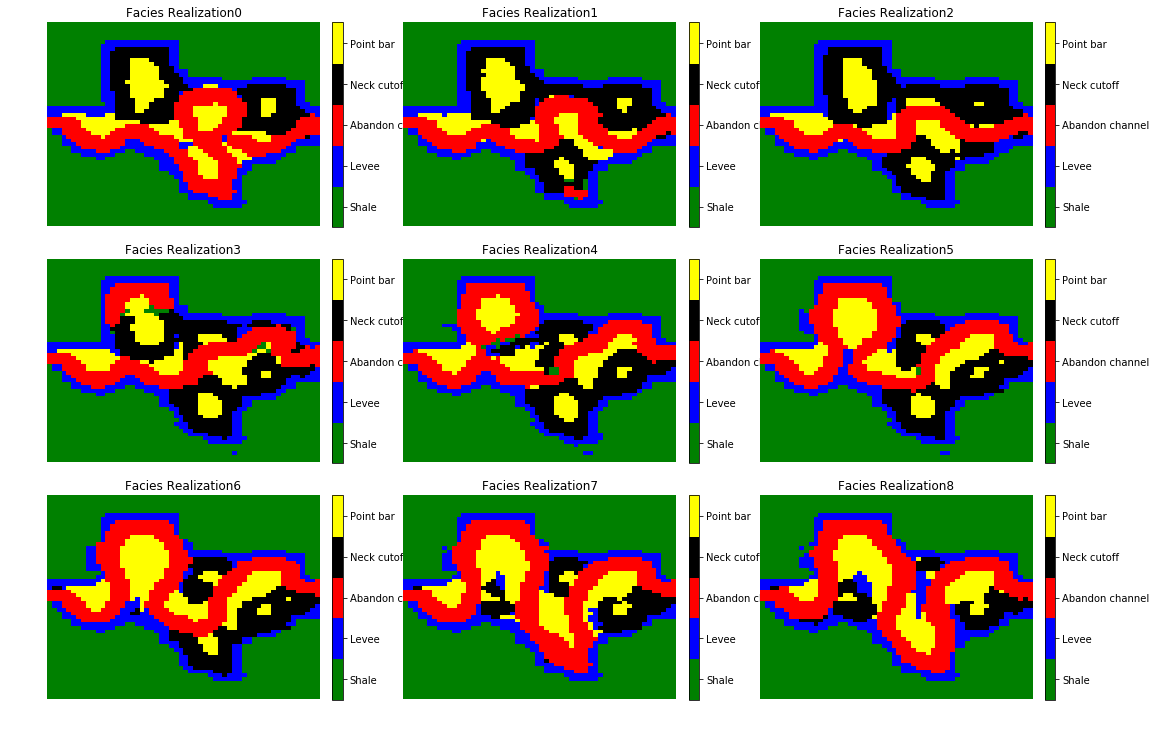

In [91]:

res0=np.random.normal(0,1,(1,56,56,1))

res1=np.random.normal(0,1,(1,56,56,1))

N=9
theta=np.linspace(0,np.pi,N)

res=np.zeros((N,56,56,1))
for i in range(N):
    res[i]=res0[0]*np.sin(theta[i])+res1[0]*np.cos(theta[i])

seismic=to_categorical(image_resized,num_classes=2)
seismic=np.tile(seismic,(N,1,1,1))
#conditional reservoir model generation
myfacies,pred_seismic=generator.predict([seismic,res])
facemaps(myfacies)

## <a>5. Summary: </a>

o. Models generated with stochastic pix2pix shows good conformance at the boundary of seismic interpretation.
o. Continuous changes in latent space correspond to continuous change in model space, the change in model space is consistent with depositional rules.
o. Stochastic pix2pix provides a very useful tool for model parameterization (model reduction), it can generate models that are "softly" conditioned to the data. It should greatly assist various inversion process for the field data.